# Qwen2 implemented from scratch with kvcache
in this file, i implemented qwen2-7B from scratch, one tensor and matrix multiplication at a time.
<br><br>
the weights is huggingface format, suffix with safetensors.
<br><br>
use "Genius is one percent inspiration and" as prompt and generate result "ninety-nine percent perspiration." in an auto-regressive manner.
<br><br>
Cache the vector of k and v during the prefill phase. and load it in decoder phase.

从头开始实现Qwen2，支持huggingface格式，以safetensors为后缀的权重，并支持kvcache，进行自回归推理。

以 "Genius is one percent inspiration and" 作为输入的prompt，先进行prefill的并行运算，生成并缓存 k 和 v，然后进行自回归生成，将前一次输出作为下一次输入，同时加载缓存的kvcache，进行推理，逐个token生成"ninety-nine percent perspiration"。

前面的推理和原过程是一样的，只是在迭代layer生成第一个token时，缓存了k和v。生成第一个token之后，将其作为输入，是新增部分。

这里以Qwen2-7B为例，其他不同大小的模型需要修改个别参数适配。

## tokenizer

In [176]:
from tokenizers import Tokenizer as TokenizerFast
import os

model_path = "/mnt/Workspace/llm-weights/qwen/Qwen/qwen/Qwen2-7B"

tokenizer = TokenizerFast.from_file(os.path.join(model_path, 'tokenizer.json'))
tokenizer.decode(tokenizer.encode("hello world!").ids)

'hello world!'

## reading the model file
normally, reading this depends on how the model classes are written and the variable names inside them.
<br>
but since we are implementing qwen1.5 from scratch we will read the file one tensor at a time.

In [177]:
from safetensors import safe_open
model = {}
for i in range(1,5):  # 遍历加载权重文件，不同大小的模型需要针对性修改
    with safe_open(os.path.join(model_path, f"model-0000{i}-of-00004.safetensors"), framework="pt", device="cpu") as f:
        count = 1
        for k in f.keys():
            model[k] = f.get_tensor(k)
            count += 1
            if count < 20 and i == 1:   # 仅显示部分权重及其shape，作为示例
                print(k, model[k].shape)

model.embed_tokens.weight torch.Size([152064, 3584])
model.layers.0.input_layernorm.weight torch.Size([3584])
model.layers.0.mlp.down_proj.weight torch.Size([3584, 18944])
model.layers.0.mlp.gate_proj.weight torch.Size([18944, 3584])
model.layers.0.mlp.up_proj.weight torch.Size([18944, 3584])
model.layers.0.post_attention_layernorm.weight torch.Size([3584])
model.layers.0.self_attn.k_proj.bias torch.Size([512])
model.layers.0.self_attn.k_proj.weight torch.Size([512, 3584])
model.layers.0.self_attn.o_proj.weight torch.Size([3584, 3584])
model.layers.0.self_attn.q_proj.bias torch.Size([3584])
model.layers.0.self_attn.q_proj.weight torch.Size([3584, 3584])
model.layers.0.self_attn.v_proj.bias torch.Size([512])
model.layers.0.self_attn.v_proj.weight torch.Size([512, 3584])
model.layers.1.input_layernorm.weight torch.Size([3584])
model.layers.1.mlp.down_proj.weight torch.Size([3584, 18944])
model.layers.1.mlp.gate_proj.weight torch.Size([18944, 3584])
model.layers.1.mlp.up_proj.weight torch

In [178]:
import json
with open(os.path.join(model_path, 'config.json'), "r") as f:   
    config = json.load(f)
config

{'architectures': ['Qwen2ForCausalLM'],
 'attention_dropout': 0.0,
 'bos_token_id': 151643,
 'eos_token_id': 151643,
 'hidden_act': 'silu',
 'hidden_size': 3584,
 'initializer_range': 0.02,
 'intermediate_size': 18944,
 'max_position_embeddings': 131072,
 'max_window_layers': 28,
 'model_type': 'qwen2',
 'num_attention_heads': 28,
 'num_hidden_layers': 28,
 'num_key_value_heads': 4,
 'rms_norm_eps': 1e-06,
 'rope_theta': 1000000.0,
 'sliding_window': 131072,
 'tie_word_embeddings': False,
 'torch_dtype': 'bfloat16',
 'transformers_version': '4.37.2',
 'use_cache': True,
 'use_sliding_window': False,
 'vocab_size': 152064}

## we use this config to infer details about the model like
1. the model has 40 transformer layers
2. each multi-head attention block has 20 heads
3. the vocab size and so on

In [179]:
import torch
dim = config["hidden_size"]
n_layers = config["num_hidden_layers"]
n_heads = config["num_attention_heads"]
n_kv_heads = config["num_key_value_heads"]
vocab_size = config["vocab_size"]
# multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["intermediate_size"]
norm_eps = config["rms_norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

## converting text to tokens
here we use tiktoken (i think an openai library) as the tokenizer

In [180]:
# prompt = "the answer to the ultimate question of life, the universe, and everything is "
# prompt = "Failure is the mother of"
# prompt = "Genius is one percent inspiration and"   # generate “ninety-nine percent perspiration.”
prompt = "君不见黄河之水天上来，奔流"   # generate “ninety-nine percent perspiration.”
tokens = tokenizer.encode(prompt).ids
print(tokens)
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)

[101956, 101571, 106536, 53930, 52510, 35727, 105442, 3837, 100524, 88653]
['君', '不见', '黄河', '之', '水', '天', '上来', '，', '奔', '流']


## converting tokens to their embedding
IM SORRY but this is the only part of the codebase where i use an inbuilt neural network module
<br>
anyway, so our [7x1] tokens are now [2560], i.e. 7 embeddings (one for each token) of length 2560
<br>
<br>
note: keep track of the shapes, it makes it much easier to understand everything

In [181]:
embedding_layer = torch.nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model["model.embed_tokens.weight"])
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
token_embeddings_unnormalized.shape

torch.Size([10, 3584])

## we then normalize the embedding using rms normalization
please, note after this step the shapes dont change, the values are just normalized
<br>
things to keep in mind, we need a norm_eps (from config) because we dont want to accidently set rms to 0 and divide by 0
<br>
here is the formula:

In [182]:
# def rms_norm(tensor, norm_weights):
#     rms = (tensor.pow(2).mean(-1, keepdim=True) + norm_eps)**0.5
#     return tensor * (norm_weights / rms)
def rms_norm(tensor, norm_weights):
    return (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)) * norm_weights

# building the first layer of the transformer

### normalization
you will see me accessing layer.0 from the model dict (this is the first layer)
<br>
anyway, so after normalizing our shapes are still [7x2560] same as embedding but normalized 

In [183]:
token_embeddings = rms_norm(token_embeddings_unnormalized, model["model.layers.0.input_layernorm.weight"])
token_embeddings.shape

torch.Size([10, 3584])

### attention implemented from scratch
let's load the attention heads of the first layer of the transformer

&gt; when we load the query, key, value and output vectors from the model we notice the shapes to be [2560x2560], [2560x2560], [2560x2560], [2560x2560]
<br>
&gt; at first glance this is weird because ideally we want each q,k,v and o for each head individually
<br>
&gt; the authors of the code bundled them togeather because its easy it helps parallize attention head multiplication.
<br>
&gt; im going to unwrap everything... 

In [184]:
print(
    model["model.layers.0.self_attn.q_proj.weight"].shape,
    model["model.layers.0.self_attn.q_proj.bias"].shape,
    model["model.layers.0.self_attn.k_proj.weight"].shape,
    model["model.layers.0.self_attn.k_proj.bias"].shape,
    model["model.layers.0.self_attn.v_proj.weight"].shape,
    model["model.layers.0.self_attn.v_proj.bias"].shape,
    model["model.layers.0.self_attn.o_proj.weight"].shape
)

torch.Size([3584, 3584]) torch.Size([3584]) torch.Size([512, 3584]) torch.Size([512]) torch.Size([512, 3584]) torch.Size([512]) torch.Size([3584, 3584])


### unwrapping query
in the next section we will unwrap the queries from multiple attention heads, the resulting shape is [20x128x2560]
<br><br>
here, 20 is the number of attention heads in qwen1.5-4B, 128 is the size of the query vector and 2560 is the size of the token embedding

In [185]:
q_layer0 = model["model.layers.0.self_attn.q_proj.weight"]
head_dim = q_layer0.shape[0] // n_heads
#q_layer0 = q_layer0.view(n_heads, 2, head_dim//2, dim).permute(0,2,1,3).reshape(n_heads, head_dim, dim)
q_layer0 = q_layer0.reshape(n_heads, head_dim, dim)
print(q_layer0.shape)

q_layer0_bias = model["model.layers.0.self_attn.q_proj.bias"]
q_layer0_bias = q_layer0_bias.reshape(n_heads, -1)
print(q_layer0_bias.shape)

torch.Size([28, 128, 3584])
torch.Size([28, 128])


### im going to implement the first head of the first layer
here i access the query weight matrix first head of the first layer, the size of this query weight matrix is [128x2560]

In [186]:
q_layer0_head0 = q_layer0[0]
q_layer0_head0.shape

torch.Size([128, 3584])

In [187]:
q_layer0_bias_head0 = q_layer0_bias[0]
q_layer0_bias_head0.shape

torch.Size([128])

### we now multiply the query weights with the token embedding, to recive a query for the token
here you can see the resulting shape is [7x128], this is because we have 7 tokens and for each token there is a 128 length query.

In [188]:
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T) + q_layer0_bias_head0
q_per_token.shape

torch.Size([10, 128])

## positioning encoding
we are now at a stage where we have a query vector for each token in our prompt, but if you think about it -- the indivitually query vector has no idea about the position in the prompt.
<br><br>
query: "the answer to the ultimate question of life, the universe, and everything is "
<br><br>
in our prompt we have used "the" three times, we need the query vectors of all 3 "the" tokens to have different query vectors (each of size [1x128]) based on their positions in the query. we perform these rotations using RoPE (rotory positional embedding).
<br><br>
### RoPE
watch this video (this is what i watched) to understand the math.
https://www.youtube.com/watch?v=o29P0Kpobz0&t=530s

In [189]:
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
q_per_token_split_into_pairs.shape

torch.Size([10, 64, 2])

in the above step, we split the query vectors into pairs, we apply a rotational angle shift to each pair!
<br><br>
we now have a vector of size [7x64x2], this is the 128 length queries split into 64 pairs for each token in the prompt! each of those 64 pairs will be rotated by m*(theta) where m is the position of the token for which we are rotating the query!

## using dot product of complex numbers to rotate a vector

In [190]:
zero_to_one_split_into_64_parts = torch.tensor(range(64))/64
zero_to_one_split_into_64_parts

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])

In [191]:
freqs = 1.0 / (rope_theta ** zero_to_one_split_into_64_parts)
freqs

tensor([1.0000e+00, 8.0584e-01, 6.4938e-01, 5.2330e-01, 4.2170e-01, 3.3982e-01,
        2.7384e-01, 2.2067e-01, 1.7783e-01, 1.4330e-01, 1.1548e-01, 9.3057e-02,
        7.4989e-02, 6.0430e-02, 4.8697e-02, 3.9242e-02, 3.1623e-02, 2.5483e-02,
        2.0535e-02, 1.6548e-02, 1.3335e-02, 1.0746e-02, 8.6596e-03, 6.9783e-03,
        5.6234e-03, 4.5316e-03, 3.6517e-03, 2.9427e-03, 2.3714e-03, 1.9110e-03,
        1.5399e-03, 1.2409e-03, 1.0000e-03, 8.0584e-04, 6.4938e-04, 5.2330e-04,
        4.2170e-04, 3.3982e-04, 2.7384e-04, 2.2067e-04, 1.7783e-04, 1.4330e-04,
        1.1548e-04, 9.3057e-05, 7.4989e-05, 6.0430e-05, 4.8697e-05, 3.9242e-05,
        3.1623e-05, 2.5483e-05, 2.0535e-05, 1.6548e-05, 1.3335e-05, 1.0746e-05,
        8.6596e-06, 6.9783e-06, 5.6234e-06, 4.5316e-06, 3.6517e-06, 2.9427e-06,
        2.3714e-06, 1.9110e-06, 1.5399e-06, 1.2409e-06])

In [192]:
abc = torch.arange(len(tokens))
abc.shape
torch.outer(abc, abc)

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18],
        [ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27],
        [ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36],
        [ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45],
        [ 0,  6, 12, 18, 24, 30, 36, 42, 48, 54],
        [ 0,  7, 14, 21, 28, 35, 42, 49, 56, 63],
        [ 0,  8, 16, 24, 32, 40, 48, 56, 64, 72],
        [ 0,  9, 18, 27, 36, 45, 54, 63, 72, 81]])

torch.Size([10, 64])
torch.Size([10, 64])


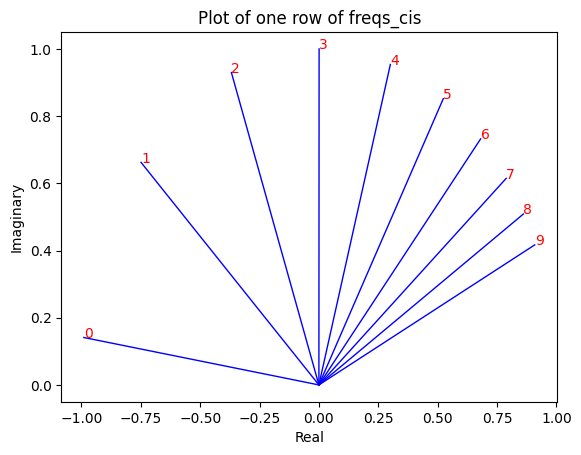

In [193]:
import matplotlib.pyplot as plt
freqs_for_each_token = torch.outer(torch.arange(len(tokens)), freqs)
print(freqs_for_each_token.shape)
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
print(freqs_cis.shape)

# viewing tjhe third row of freqs_cis
value = freqs_cis[3]
plt.figure()
for i, element in enumerate(value[:len(tokens)]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Plot of one row of freqs_cis')
plt.show()

### now that we have a complex number (the angle change vector) for every token's query element
we can convert our queries (the one we split into pairs) as complex numbers and then dot product to rotate the query based on the position
<br>
honeslty this is beautiful to think about :)

In [194]:
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
q_per_token_as_complex_numbers.shape

torch.Size([10, 64])

In [195]:
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis
q_per_token_as_complex_numbers_rotated.shape

torch.Size([10, 64])

### after rotated vector is obtained
we can get back our the queries as pairs by viewing the complex numbers as real numbers again

In [196]:
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)
q_per_token_split_into_pairs_rotated.shape

torch.Size([10, 64, 2])

the rotated pairs are now merged, we now have a new query vector (rotated query vector) that is of the shape [7x128] where 7 is the number of tokens and the 128 is the dim of the query vector

In [197]:
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
q_per_token_rotated.shape

torch.Size([10, 128])

# keys (almost the same as queries)
im lazy as fuck, so im not going to go through the math for keys, the only things you need to keep in mind are:
<br>
&gt; keys generate key vectors also of dimention 128
<br>
&gt; the number of keys equal to number of queries, qwen1.5-4B use MHA, instead of GQA
<br>
&gt; keys are also rotated to add positional info, just like queries because of the same reasons 

In [198]:
k_layer0 = model["model.layers.0.self_attn.k_proj.weight"]
k#_layer0 = k_layer0.view(n_kv_heads, 2, k_layer0.shape[0] // n_kv_heads//2, dim).permute(0,2,1,3).reshape(n_kv_heads, k_layer0.shape[0]// n_kv_heads, dim)
k_layer0 = k_layer0.reshape(n_kv_heads, k_layer0.shape[0]// n_kv_heads, dim)
print(k_layer0.shape)

k_layer0_bias = model["model.layers.0.self_attn.k_proj.bias"]
k_layer0_bias = k_layer0_bias.reshape(n_kv_heads, -1)
print(k_layer0_bias.shape)

torch.Size([4, 128, 3584])
torch.Size([4, 128])


In [199]:
k_layer0_head0 = k_layer0[0]
k_layer0_head0.shape

torch.Size([128, 3584])

In [200]:
k_layer0_bias_head0 = k_layer0_bias[0]
k_layer0_bias_head0.shape

torch.Size([128])

In [201]:
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T) + k_layer0_bias_head0
k_per_token.shape

torch.Size([10, 128])

In [202]:
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
k_per_token_split_into_pairs.shape

torch.Size([10, 64, 2])

In [203]:
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
k_per_token_as_complex_numbers.shape

torch.Size([10, 64])

In [204]:
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
k_per_token_split_into_pairs_rotated.shape

torch.Size([10, 64, 2])

In [205]:
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
k_per_token_rotated.shape

torch.Size([10, 128])

## at this stage now have both the rotated values of queries and keys, for each token. 
each of the queries and keys are now of shape [7x128]. 

## in the next step we will multiply the queries and key matrices
doing this will give us a score mapping each token with one another
<br>
this score describes how well each token's query relates to the each tokens's key. 
THIS IS SELF ATTENTION :)
<br>
the shape of the attention score matrix (qk_per_token) is [7x7] where 7 is the number of tokens in the prompt

In [206]:
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5
qk_per_token.shape

torch.Size([10, 10])

# we now have to mask query key scores
during the training process of qwen, the future token qk scores are masked.
<br>
why? because during training we only learn to predict tokens using past tokens.
<br>
as a result, during inference we set the future tokens to zero.

/opt/Envs/miniconda3/envs/torch2.2/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 21531 (\N{CJK UNIFIED IDEOGRAPH-541B}) missing from current font.
  func(*args, **kwargs)
/opt/Envs/miniconda3/envs/torch2.2/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from current font.
  func(*args, **kwargs)
/opt/Envs/miniconda3/envs/torch2.2/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 35265 (\N{CJK UNIFIED IDEOGRAPH-89C1}) missing from current font.
  func(*args, **kwargs)
/opt/Envs/miniconda3/envs/torch2.2/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 40644 (\N{CJK UNIFIED IDEOGRAPH-9EC4}) missing from current font.
  func(*args, **kwargs)
/opt/Envs/miniconda3/envs/torch2.2/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 27827 (\N{CJK UNIFIED IDEOGRAPH-6CB3}) missing from current font.
  func(*args, **kwargs)
/opt/

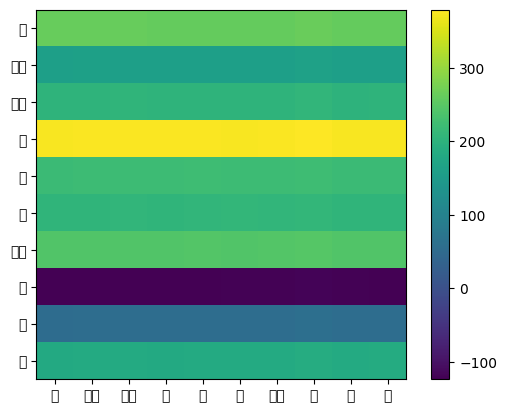

In [207]:
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens)
    ax.set_yticklabels(prompt_split_as_tokens)
    ax.figure.colorbar(im, ax=ax)
    
display_qk_heatmap(qk_per_token)

In [208]:
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

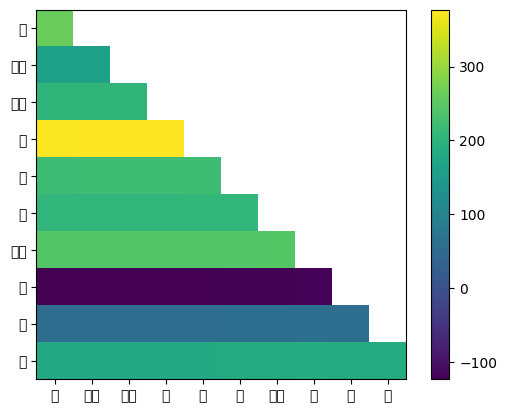

In [209]:
qk_per_token_after_masking = qk_per_token + mask
display_qk_heatmap(qk_per_token_after_masking)

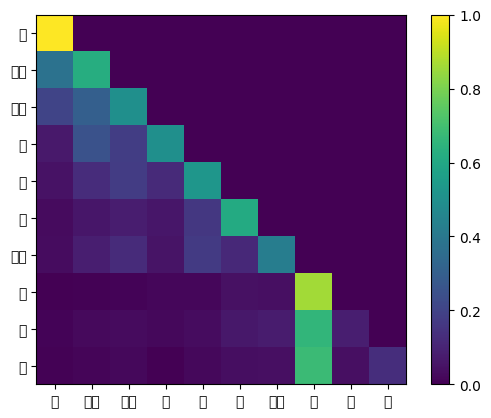

In [210]:
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

## values (almost the end of attention)
these scores (0-1) are used to determine how much of value matrix is used per token
<br>
&gt; just like keys, value weights are also shared acorss every 4 attention heads (to save computation)
<br>
&gt; as a result, the shape of the value weight matrix below is [20x128x2560]


In [211]:
v_layer0 = model["model.layers.0.self_attn.v_proj.weight"]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)
print(v_layer0.shape)

v_layer0_bias = model["model.layers.0.self_attn.v_proj.bias"]
v_layer0_bias = v_layer0_bias.reshape(n_kv_heads, -1)
print(v_layer0_bias.shape)

torch.Size([4, 128, 3584])
torch.Size([4, 128])


the first layer, first head value weight matrix is given below

In [212]:
v_layer0_head0 = v_layer0[0]
v_layer0_head0.shape

torch.Size([128, 3584])

In [213]:
v_layer0_bias_head0 = v_layer0_bias[0]
v_layer0_bias_head0.shape

torch.Size([128])

## value vectors
we now use the value weghts to get the attention values per token, this is of size [7x128] where 7 is the number of tokens in the prompt and 128 is the dim of the value vector per token

In [214]:
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T) + v_layer0_bias_head0
v_per_token.shape

torch.Size([10, 128])

## attention
the resultant attention vector after multipying with the values per token is of shape [7*128]

In [215]:
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
qkv_attention.shape

torch.Size([10, 128])

# multi head attention
WE NOW HAVE THE ATTENTION VALUE OF THE FIRST LAYER AND FIRST HEAD
<br>
now im going to run a loop and perform the exact same math as the cells above but for every head in the first layer

In [216]:
qkv_attention_store = []
GQA_num = n_heads // n_kv_heads # 
for head in range(n_heads):
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head//GQA_num] 
    v_layer0_head = v_layer0[head//GQA_num]
    q_layer0_bias_head = q_layer0_bias[head]
    k_layer0_bias_head = k_layer0_bias[head//GQA_num]
    v_layer0_bias_head = v_layer0_bias[head//GQA_num]
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T) + q_layer0_bias_head
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T) + k_layer0_bias_head
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T) + v_layer0_bias_head

    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token + mask
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention_store.append(qkv_attention)

len(qkv_attention_store)

28

we now have a the qkv_attention matrix for all 20 heads on the first layer, next im going to merge all attention scores into one large matrix of size [7x2560]
<br>
we are almost at the end :)

In [217]:
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
stacked_qkv_attention.shape

torch.Size([10, 3584])

# weight matrix, one of the final steps
one of the last things to do for a layer 0 attention is, is to multiply the weight matrix of the 

In [218]:
w_layer0 = model["model.layers.0.self_attn.o_proj.weight"]
w_layer0.shape

torch.Size([3584, 3584])

### this is a simple linear layer, so we just matmul

In [219]:
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)
embedding_delta.shape

torch.Size([10, 3584])

we now have the change in the embedding value after attention, that should be adding to the original token embeddings

In [220]:
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
embedding_after_edit.shape

torch.Size([10, 3584])

## we normalize and then run a feed forward neural network through the embedding delta

In [221]:
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["model.layers.0.post_attention_layernorm.weight"])
embedding_after_edit_normalized.shape

torch.Size([10, 3584])

## loading the ff weights and implementing the feed forward network
in qwen1.5, they used a SwiGLU feedforward network, this network architecture is really good at adding non linearity when needed by the model.
<br>
its pretty standard to use this feed forward network architecture in llms these days

In [222]:
w1 = model["model.layers.0.mlp.gate_proj.weight"]
w2 = model["model.layers.0.mlp.down_proj.weight"]
w3 = model["model.layers.0.mlp.up_proj.weight"]
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_feedforward.shape

torch.Size([10, 3584])

# WE FINALLY HAVE NEW EDITED EMBEDDINGS FOR EACH TOKEN AFTER THE FIRST LAYER
just 39 more layers to go before we are done (one for loop away)
<br>
you can imagine this edited embedding as having information about all queries asked on the first layer
<br>
now each layer will encode more and more complex queries on the quesions asked, until we have an embedding that knows everything about the next token that we need.

In [223]:
layer_0_embedding = embedding_after_edit+output_after_feedforward
layer_0_embedding.shape

torch.Size([10, 3584])

# god, everything all at once
yep, this is it. everything we did before, all at once, for every single layer.
<br>

# have fun reading :)

In [224]:
k_cache, v_cache = [], []   # init k v cache

In [225]:
final_embedding = token_embeddings_unnormalized
GQA_num = n_heads // n_kv_heads
for layer in range(n_layers):
    k_cache.append([])
    v_cache.append([])
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"model.layers.{layer}.input_layernorm.weight"])
    q_layer = model[f"model.layers.{layer}.self_attn.q_proj.weight"]
    #q_layer = q_layer.view(n_heads, 2, q_layer.shape[0] // n_heads // 2, dim).permute(0, 2, 1, 3).reshape(n_heads, q_layer.shape[0] // n_heads, dim)
    q_layer = q_layer.reshape(n_heads, q_layer.shape[0] // n_heads, dim)
    q_layer_bias = model[f"model.layers.{layer}.self_attn.q_proj.bias"]
    q_layer_bias = q_layer_bias.reshape(n_heads, -1)
    k_layer = model[f"model.layers.{layer}.self_attn.k_proj.weight"]
    #k_layer = k_layer.view(n_kv_heads, 2, k_layer.shape[0] // n_kv_heads // 2, dim).permute(0, 2, 1, 3).reshape(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    k_layer = k_layer.reshape(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    k_layer_bias = model[f"model.layers.{layer}.self_attn.k_proj.bias"]
    k_layer_bias = k_layer_bias.reshape(n_kv_heads, -1)
    v_layer = model[f"model.layers.{layer}.self_attn.v_proj.weight"]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    v_layer_bias = model[f"model.layers.{layer}.self_attn.v_proj.bias"]
    v_layer_bias = v_layer_bias.reshape(n_kv_heads, -1)
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//GQA_num]
        v_layer_head = v_layer[head//GQA_num]
        q_layer_bias_head = q_layer_bias[head]
        k_layer_bias_head = k_layer_bias[head//GQA_num]
        v_layer_bias_head = v_layer_bias[head//GQA_num]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T) + q_layer_bias_head
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T) + k_layer_bias_head
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T) + v_layer_bias_head
        if head % GQA_num == 0:   # qwen1.5-4B use MHA，GQA_num=1
            v_cache[-1].append(v_per_token)   # cache v vector
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis)
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
        if head % GQA_num == 0:   # 
            k_cache[-1].append(k_per_token)  # cache k vector
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"model.layers.{layer}.self_attn.o_proj.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"model.layers.{layer}.post_attention_layernorm.weight"])
    w1 = model[f"model.layers.{layer}.mlp.gate_proj.weight"] 
    w2 = model[f"model.layers.{layer}.mlp.down_proj.weight"]
    w3 = model[f"model.layers.{layer}.mlp.up_proj.weight"]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    final_embedding = embedding_after_edit+output_after_feedforward

In [226]:
# k v cache info
print(k_cache[0][0].shape)
print(k_cache[0][-1].shape)
print(len(k_cache))
print(len(k_cache[0]))
print(v_cache[0][0].shape)
print(v_cache[0][-1].shape)
print(len(v_cache))
print(len(v_cache[0]))

torch.Size([10, 128])
torch.Size([10, 128])
28
4
torch.Size([10, 128])
torch.Size([10, 128])
28
4


# we now have the final embedding, the best guess the model could make about the next token
the shape of the embedding is the same as regular token embeddings [7x2560] where 7 is the number of tokens and 2560 is the embedding dim

In [227]:
final_embedding = rms_norm(final_embedding, model["model.norm.weight"])
final_embedding.shape

torch.Size([10, 3584])

# finally, lets decode the embedding into the token value
we will use the output decoder to convert the final embedding into a token

In [228]:
model["lm_head.weight"].shape

torch.Size([152064, 3584])

# we use the embedding of the last token to predict the next value
hopefully in our case: ninety 

In [229]:
logits = torch.matmul(final_embedding[-1], model["lm_head.weight"].T)
#logits = torch.matmul(final_embedding, model["lm_head.weight"].T)
logits.shape

torch.Size([152064])

### the model predicted token number 77876 as the next token, is this the token number for ninety?
IM HYPING YOU UP, this is the last cell of code, hopefully you had fun :)

In [230]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(53930)

# lets fucking go

In [231]:
tokenizer.decode([next_token.item()])
#tokenizer.decode(list(next_token.numpy()))

'之'

# Prefill stage is finish, we get the k_cache and v_cache for input_token.
we also get a output(next token), and we can use it as a input token for generat next token. This is the feature for Decoder only model.
##### 预填充阶段推理完成，并生成第一个token。同时缓存了prompt阶段过程中生成的k和v，用于下一阶段进行decoder推理，进行自回归生成，同时加载前面生成的k和v，进行加速推理。

In [232]:
max_new_len = 8
seq_len = len(tokens)
GQA_num = n_heads // n_kv_heads # 1

In [233]:
next_token = torch.tensor([next_token.item()])
for _ in range(max_new_len-1):
    print(next_token[-1].item())
    if next_token[-1].item() == 151643:    # 151643 is "<|end_of_text|>"
        break
    next_token = next_token[-1:]
    next_token_embeddings_unnormalized = embedding_layer(next_token).to(torch.bfloat16)

    final_embedding = next_token_embeddings_unnormalized
    for layer in range(n_layers):
        qkv_attention_store = []
        layer_embedding_norm = rms_norm(final_embedding, model[f"model.layers.{layer}.input_layernorm.weight"])
        q_layer = model[f"model.layers.{layer}.self_attn.q_proj.weight"]
        q_layer = q_layer.reshape(n_heads, q_layer.shape[0] // n_heads, dim)
        q_layer_bias = model[f"model.layers.{layer}.self_attn.q_proj.bias"]
        q_layer_bias = q_layer_bias.reshape(n_heads, -1)
        k_layer = model[f"model.layers.{layer}.self_attn.k_proj.weight"]
        k_layer = k_layer.reshape(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
        k_layer_bias = model[f"model.layers.{layer}.self_attn.k_proj.bias"]
        k_layer_bias = k_layer_bias.reshape(n_kv_heads, -1)
        v_layer = model[f"model.layers.{layer}.self_attn.v_proj.weight"]
        v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
        v_layer_bias = model[f"model.layers.{layer}.self_attn.v_proj.bias"]
        v_layer_bias = v_layer_bias.reshape(n_kv_heads, -1)
        for head in range(n_heads):
            q_layer_head = q_layer[head]
            k_layer_head = k_layer[head//GQA_num]
            v_layer_head = v_layer[head//GQA_num]
            q_layer_bias_head = q_layer_bias[head]
            k_layer_bias_head = k_layer_bias[head//GQA_num]
            v_layer_bias_head = v_layer_bias[head//GQA_num]
            q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T) + q_layer_bias_head
            q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
            q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
            freqs_for_next_token = torch.outer(torch.tensor([seq_len]), freqs)
            freqs_cis_next_token = torch.polar(torch.ones_like(freqs_for_next_token), freqs_for_next_token)
            q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis_next_token)
            q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

            if head % GQA_num == 0:
                v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T) + v_layer_bias_head
                v_cache[layer][head//GQA_num] = torch.cat([v_cache[layer][head//GQA_num], v_per_token], dim=0)    # update v_cache

                k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T) + k_layer_bias_head
                k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
                k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
                k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis_next_token)
                k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
                k_cache[layer][head//GQA_num] = torch.cat([k_cache[layer][head//GQA_num], k_per_token_rotated], dim=0)    # update k_cache
                
            qk_per_token = torch.matmul(q_per_token_rotated, k_cache[layer][head//GQA_num].T)/(128)**0.5
            #mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))   # don't need mask
            #mask = torch.triu(mask, diagonal=1)
            qk_per_token_after_masking = qk_per_token  # + mask
            qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
            qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_cache[layer][head//GQA_num])
            qkv_attention_store.append(qkv_attention)

        stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
        w_layer = model[f"model.layers.{layer}.self_attn.o_proj.weight"]
        embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
        embedding_after_edit = final_embedding + embedding_delta
        embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"model.layers.{layer}.post_attention_layernorm.weight"])
        w1 = model[f"model.layers.{layer}.mlp.gate_proj.weight"] 
        w2 = model[f"model.layers.{layer}.mlp.down_proj.weight"]
        w3 = model[f"model.layers.{layer}.mlp.up_proj.weight"]
        output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
        final_embedding = embedding_after_edit+output_after_feedforward
    
    final_embedding = rms_norm(final_embedding, model["model.norm.weight"])
    #print("final_embedding.shape: ", final_embedding.shape)
    logits = torch.matmul(final_embedding, model["lm_head.weight"].T)
    #print("logits.shape: ", logits.shape)
    next_token = torch.argmax(logits, dim=-1)
    #print("next_token: ", next_token)
    print("token decode: ", tokenizer.decode([next_token.item()]))
    seq_len += 1

53930


token decode:  水
52510
token decode:  ，
3837
token decode:  奔
100524
token decode:  流
88653
token decode:  之
53930
token decode:  ，
3837
token decode:  之


# thank you, i love you :)

This is the end. Hopefully you enjoyed reading it!